# 4.3 GridSearch XGB

without validation data




## 1. Imports

In [27]:
import os
from pathlib import Path
import json
import warnings
from typing import Dict, List, Optional, Tuple, Union

# Add src to path
print(os.getcwd())

import pandas as pd
import numpy as np

# ML libraries
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix
)
from sklearn import set_config

# Models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Sampling
from imblearn.pipeline import Pipeline


# Custom utilities
from src.utils.preprocessing import (
    load_processed_dataset,
    DatasetSplit,
    build_full_suffix as pp_build_full_suffix,
    generate_all_processed_datasets,
    _normalize_sampling_method_name,
    _SAMPLING_REGISTRY
)
from src.utils.evaluation import eval_model
from src.utils.model_saver import create_model_saver

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

/home/christianm/Projects/Repos/heartbeat_classification


## 2. Refit best Model from part 4

In [ ]:
RANDOM_STATE = 42
SCORING = {'f1_macro': 'f1_macro', 'bal_acc': 'balanced_accuracy', 'f1_weighted': 'f1_weighted'}
results_csv = "reports/03_model_testing_results/04_01_model_comparison_grid_search_best_models.csv"

PARAM_SPACES = {
    "XGBoost": {
        "estimator": xgb.XGBClassifier(
            objective="binary:logistic",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric="logloss",
        ),
        "params": {
            "n_estimators": [350, 500], # [150, 200, 250, 350, 500],
            "max_depth": [8, 9],
            "learning_rate": [0.1, 0.2, 0.3],
            "subsample": [0.6, 0.7, 0.8],
            "colsample_bytree": [0.9],
            "reg_alpha": [0.1, 0.2],
            "reg_lambda": [0.0, 0.05],
            "min_child_weight": [5],
            "gamma": [0.0, 0.05],
        },
        "cv": RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=RANDOM_STATE),
    },
}


### XGBoost, SMOTE, no outlier removal,	no feature engineering

In [ ]:
# Evaluate the fitted MIT-trained XGBoost on the entire PTB dataset (train + val)
from src.utils.preprocessing import prepare_ptbdb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


print("\n" + "="*80)
print("GridSearch on PTB Dataset to find best parameters")
print("="*80)

# Load PTB split (both train and test)
# validation is left out to compare 
ptb_dir = "/home/christianm/Projects/Repos/heartbeat_classification/data/processed/ptb"
X_ptb_train = pd.read_csv(f"{ptb_dir}/X_ptb_train.csv").values
y_ptb_train = pd.read_csv(f"{ptb_dir}/y_ptb_train.csv").iloc[:, 0].values.astype(int)
X_ptb_train_sm = pd.read_csv(f"{ptb_dir}/X_ptb_train_sm.csv").values
y_ptb_train_sm = pd.read_csv(f"{ptb_dir}/y_ptb_train_sm.csv").iloc[:, 0].values.astype(int)
X_ptb_test = pd.read_csv(f"{ptb_dir}/X_ptb_test.csv").values
y_ptb_test = pd.read_csv(f"{ptb_dir}/y_ptb_test.csv").iloc[:, 0].values.astype(int)
X_ptb_val = pd.read_csv(f"{ptb_dir}/X_ptb_val.csv").values
y_ptb_val = pd.read_csv(f"{ptb_dir}/y_ptb_val.csv").iloc[:, 0].values.astype(int)
X_ptb_full = np.vstack([X_ptb_train, X_ptb_test, X_ptb_val])
y_ptb_full = np.concatenate([y_ptb_train, y_ptb_test, y_ptb_val])

model_name = "XGBoost"
sampling_method = "SMOTE"
remove_outliers = False


GridSearch on PTB Dataset to find best parameters


In [31]:
def create_leak_free_pipeline(
    model_name: str,
    estimator,
    sampling_method: Optional[str] = "none",
    sampler_kwargs: Optional[Dict] = None,
    random_state: Optional[int] = 42,
) -> Pipeline:
    """
    Build a leak-free pipeline:
    - Using imblearn.Pipeline ensures fit/transform of SAMPLER happen within each CV fold on TRAIN only.
    """
    sampler_kwargs = dict(sampler_kwargs or {})

    # Provide a default random_state to samplers if not overridden
    if random_state is not None and "random_state" not in sampler_kwargs:
        sampler_kwargs["random_state"] = random_state

    internal_name = _normalize_sampling_method_name(sampling_method)

    steps = []

    SamplerClass = _SAMPLING_REGISTRY[internal_name]
    steps.append(("sampler", SamplerClass(**sampler_kwargs)))

    steps.append(("classifier", estimator))
    display(steps)
    return Pipeline(steps)

In [33]:
print(f"\n{'='*80}")
print(f"Running GridSearchCV for {model_name} with {sampling_method}")
print(f"Outlier removal: {remove_outliers}")
print(f"{'='*80}")

# Get model configuration
model_save_path = "src/models/04_grid_search_xgboost_ptb"
model_saver = create_model_saver(model_save_path)
model_config = PARAM_SPACES[model_name]
estimator = model_config["estimator"]
params = model_config["params"]
cv = model_config["cv"]

# Prepare data
X_train, X_test, y_train, y_test = X_ptb_train, X_ptb_test, y_ptb_train, y_ptb_test

# Create leak-free pipeline
pipeline = create_leak_free_pipeline(model_name, estimator, sampling_method)

# Adjust parameter names for pipeline
pipeline_params = {}
for param_name, param_values in params.items():
    pipeline_params[f'classifier__{param_name}'] = param_values

# Create experiment name
experiment_name = f"{sampling_method.lower()}_outliers_{remove_outliers}_350_500"

# Check if model already exists
if model_saver and model_saver.model_exists(model_name, experiment_name):
    grid_search = model_saver.load_model("XGBoost", "smote_outliers_False")
    print(f"Model {model_name} already exists for experiment {experiment_name}. Skipping training and CSV append.")
else:
    print(f"Training new model for {model_name}...")
    
    # Run GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=pipeline_params,
        scoring=SCORING,
        refit='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    # Save model if saver is provided
    if model_saver:
        metadata = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'cv_results': grid_search.cv_results_,
            'experiment': experiment_name,
            'classifier': model_name,
            'sampling_method': sampling_method,
            'remove_outliers': remove_outliers,
        }
        model_saver.save_model(model_name, grid_search, experiment_name, metadata)
        print(f"Model {model_name} saved successfully!")


Running GridSearchCV for XGBoost with SMOTE
Outlier removal: False


[('sampler', SMOTE(random_state=42)),
 ('classifier',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, feature_weights=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=-1,
                num_parallel_tree=None, ...))]

model_path=PosixPath('src/models/04_grid_search_xgboost_ptb/XGBoost_smote_outliers_False_350_500.joblib')
Training new model for XGBoost...
Fitting 15 folds for each of 288 candidates, totalling 4320 fits
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.0, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__min_child_weight=5, classifier__n_estimators=350, classifier__reg_alpha=0.1, classifier__reg_lambda=0.0, classifier__subsample=0.6; total time=  22.6s
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.0, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__min_child_weight=5, classifier__n_estimators=350, classifier__reg_alpha=0.1, classifier__reg_lambda=0.0, classifier__subsample=0.6; total time=  22.7s
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.0, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__min_child_weight=5, classifier__n_estimators=350, classifier__reg_alpha=0.1, classifier__re

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7fd73f5f0950>>
Traceback (most recent call last):
  File "/home/christianm/Projects/Repos/heartbeat_classification/.venv/lib/python3.11/site-packages/xgboost/core.py", line 630, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 
corrupted size vs. prev_size
Fatal Python error: Aborted

Current thread 0x00007fd766410b80 (most recent call first):
  File "/home/christianm/Projects/Repos/heartbeat_classification/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1823 in _init
  File "/home/christianm/Projects/Repos/heartbeat_classification/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1768 in __init__
  File "/home/christianm/Projects/Repos/heartbeat_classification/.venv/lib/python3.11/site-packages/xgboost/core.py", line 774 in inner_f
  File "/home/christian

KeyboardInterrupt: 

In [ ]:

print(f"Evaluating {model_name} on validation set...")
best_model = grid_search.best_estimator_

# Get predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average='macro', zero_division=0
)

# Per-class metrics
labels = np.unique(np.concatenate([y_train, y_test]))
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=labels, zero_division=0
)

confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)

results = {
    'model_name': model_name,
    'sampling_method': sampling_method,
    'remove_outliers': remove_outliers,
    'best_cv_score': grid_search.best_score_,
    'best_params': grid_search.best_params_,
    'validation_accuracy': accuracy,
    'validation_f1_macro': f1_macro,
    'validation_precision_macro': precision_macro,
    'validation_recall_macro': recall_macro,
    'validation_f1_per_class': f1_per_class,
    'validation_precision_per_class': precision_per_class,
    'validation_recall_per_class': recall_per_class,
    'validation_support_per_class': support_per_class,
    'confusion_matrix': confusion_mat,
    'labels': labels,
}

print(f"Validation F1-Macro: {f1_macro:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Append to results CSV
row = {
    'sampling_method': sampling_method,
    'outliers_removed': remove_outliers,
    'model': model_name,
    'test_accuracy': round(float(accuracy), 4),
    'test_f1_macro': round(float(f1_macro), 4),
    'best_cv_score': round(float(grid_search.best_score_), 4),
    'best_parameters': json.dumps(grid_search.best_params_),
}
# Add per-class F1 columns
for lbl, f1 in zip(labels, f1_per_class):
    row[f'test_f1_cls_{lbl}'] = round(float(f1), 2)

os.makedirs(os.path.dirname(results_csv), exist_ok=True)
header = not os.path.exists(results_csv)
pd.DataFrame([row]).to_csv(results_csv, mode='a', index=False, header=header)

results

Evaluating XGBoost on validation set...
Validation F1-Macro: 0.9717
Validation Accuracy: 0.9773


{'model_name': 'XGBoost',
 'sampling_method': 'SMOTE',
 'remove_outliers': False,
 'best_cv_score': np.float64(0.9641534313351916),
 'best_params': {'classifier__colsample_bytree': 0.9,
  'classifier__gamma': 0.05,
  'classifier__learning_rate': 0.1,
  'classifier__max_depth': 9,
  'classifier__min_child_weight': 5,
  'classifier__n_estimators': 250,
  'classifier__reg_alpha': 0.1,
  'classifier__reg_lambda': 0.0,
  'classifier__subsample': 0.7},
 'validation_accuracy': 0.9773117909934685,
 'validation_f1_macro': 0.9717042363619,
 'validation_precision_macro': 0.9724278511206103,
 'validation_recall_macro': 0.9709874036141033,
 'validation_f1_per_class': array([0.95910781, 0.98430067]),
 'validation_precision_per_class': array([0.96149068, 0.98336502]),
 'validation_recall_per_class': array([0.95673671, 0.9852381 ]),
 'validation_support_per_class': array([ 809, 2100]),
 'confusion_matrix': array([[ 774,   35],
        [  31, 2069]]),
 'labels': array([0, 1])}

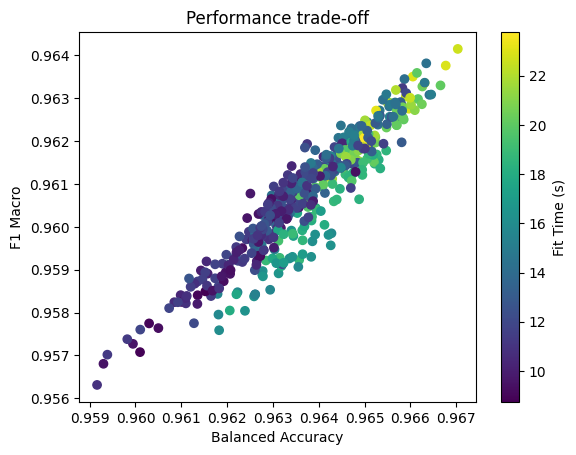

In [28]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame(grid_search.cv_results_)

plt.scatter(results_df['mean_test_bal_acc'], 
            results_df['mean_test_f1_macro'], 
            c=results_df['mean_fit_time'], cmap='viridis')
plt.xlabel('Balanced Accuracy')
plt.ylabel('F1 Macro')
plt.title('Performance trade-off')
plt.colorbar(label='Fit Time (s)')


Text(0.5, 1.0, 'Bias–variance trade-off')

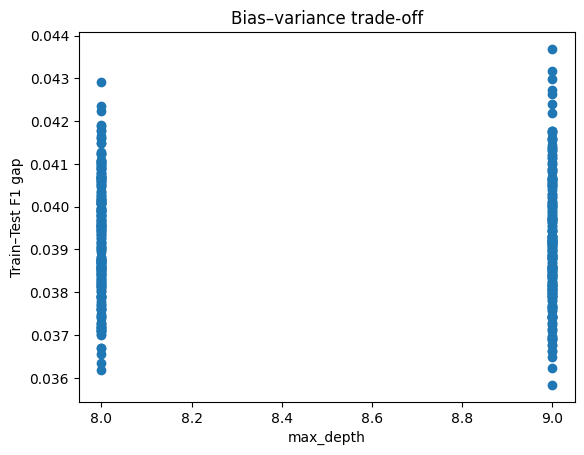

In [29]:
results_df['generalization_gap'] = (
    results_df['mean_train_f1_macro'] - results_df['mean_test_f1_macro']
)

plt.scatter(results_df['param_classifier__max_depth'],
            results_df['generalization_gap'])
plt.xlabel('max_depth')
plt.ylabel('Train–Test F1 gap')
plt.title('Bias–variance trade-off')


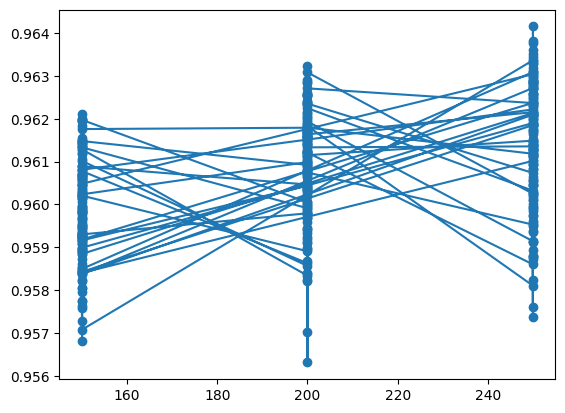

In [30]:
plt.plot(results_df['param_classifier__n_estimators'], 
         results_df['mean_test_f1_macro'], 'o-')


Text(0.5, 1.0, 'Speed–performance frontier')

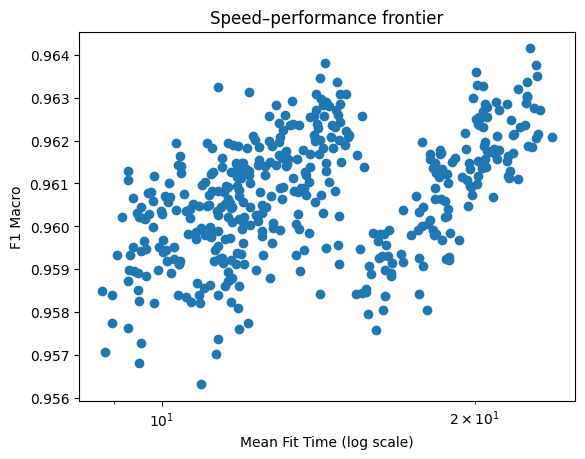

In [31]:
plt.scatter(results_df['mean_fit_time'], results_df['mean_test_f1_macro'])
plt.xscale('log')
plt.xlabel('Mean Fit Time (log scale)')
plt.ylabel('F1 Macro')
plt.title('Speed–performance frontier')


Text(0.5, 1.0, 'Metric correlation matrix')

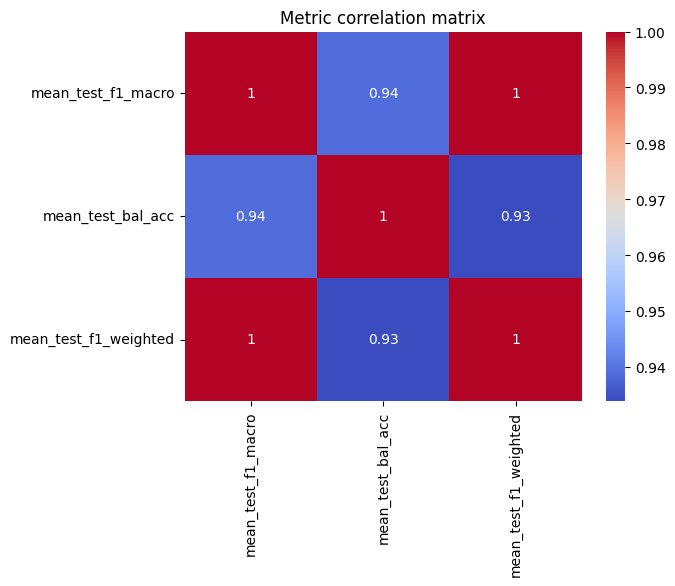

In [33]:
import seaborn as sns 
metric_cols = [c for c in results_df.columns if c.startswith('mean_test_')]
corr = results_df[metric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Metric correlation matrix')


In [38]:
from pygmo import fast_non_dominated_sorting

scores = results_df[['mean_test_f1_macro', 'mean_test_bal_acc']].to_numpy()
front_idx = fast_non_dominated_sorting(scores)[0][0]
pareto_df = results_df.iloc[front_idx]
pareto_df


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,...,split9_train_f1_weighted,split10_train_f1_weighted,split11_train_f1_weighted,split12_train_f1_weighted,split13_train_f1_weighted,split14_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,generalization_gap,f1_macro_std
414,10.902753,0.721339,0.028521,0.004995,0.9,0.05,0.3,9,5,200,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.04369,0.004001


Text(0.5, 1.0, 'Performance vs stability')

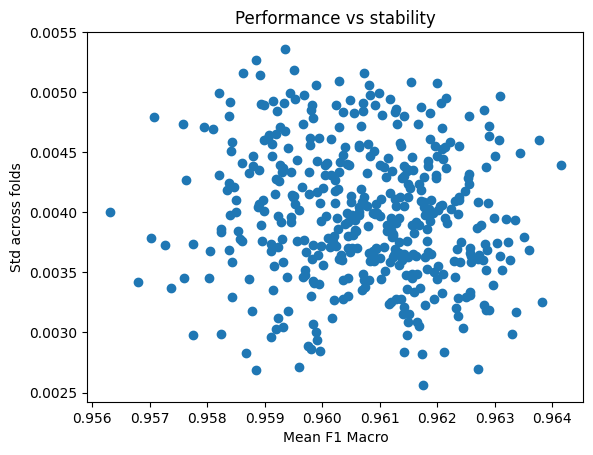

In [37]:
results_df['f1_macro_std'] = results_df['std_test_f1_macro']
plt.scatter(results_df['mean_test_f1_macro'], results_df['f1_macro_std'])
plt.xlabel('Mean F1 Macro')
plt.ylabel('Std across folds')
plt.title('Performance vs stability')


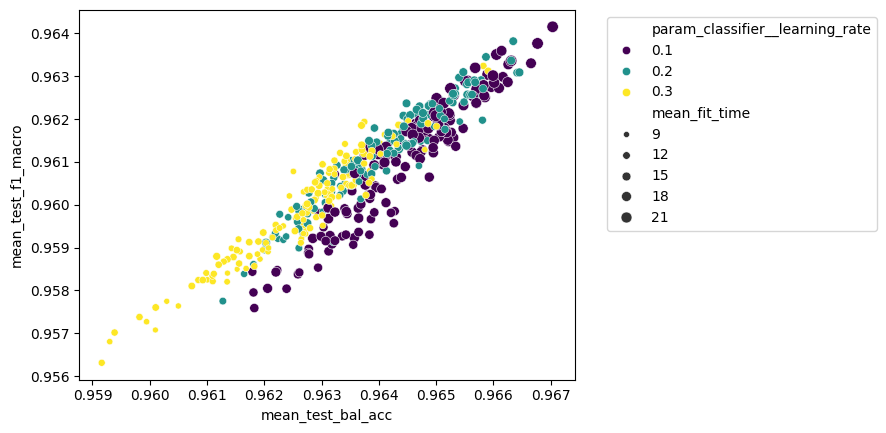

In [40]:
sns.scatterplot(
    data=results_df,
    x='mean_test_bal_acc',
    y='mean_test_f1_macro',
    size='mean_fit_time',
    hue='param_classifier__learning_rate',
    palette='viridis'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
